python=3.8
tf=2.10

**Imports**

In [36]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import csv
import math
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.layers import Embedding, LSTM, Dense, Flatten, Reshape, Dropout, Conv2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from keras import backend as K
from keras.constraints import MinMaxNorm
from keras.callbacks import LearningRateScheduler, EarlyStopping, Callback
from keras.metrics import RootMeanSquaredError
from keras.layers import Dropout,  TimeDistributed
from keras.regularizers import l2
from keras.initializers import HeNormal
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Concatenate
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, optimizers, losses, metrics

**Check to see if CUDA can find my GPU**

In [2]:
len(tf.config.list_physical_devices('GPU'))>0
tf.keras.backend.set_floatx('float64')

**Read csv file into a df and drop 'zCOM' column as it's not needed**

In [3]:
sorted_concatenated_csv = "C:/Users/Ioannis/Documents/UvA thesis/UvA-thesis/data/test_data_concat/sorted_concatenated_data.csv"
data = pd.read_csv(sorted_concatenated_csv)
data.drop(columns=['zCOM'], inplace=True)
print(data.head())

   mcsteps  xCOM  yCOM           il8  il1  il6  il10  tnf  tgf
0        0    33    22  3.750408e-07  0.0  0.0   0.0  0.0  0.0
1        0    11    32  4.793328e-09  0.0  0.0   0.0  0.0  0.0
2        0    30    35  8.997935e-09  0.0  0.0   0.0  0.0  0.0
3        0    17    40  1.781103e-08  0.0  0.0   0.0  0.0  0.0
4        0    21    23  4.789621e-09  0.0  0.0   0.0  0.0  0.0


**Replace the 'mcsteps' column with 'time' and adjust the scale to represent 0-100 hours**

In [4]:
data['time'] = (data['mcsteps'] / 10000).astype(int)
data = data[['time'] + [col for col in data.columns if col != 'time']]
data.drop(columns=['mcsteps'], inplace=True)
print(data)

       time  xCOM  yCOM           il8           il1           il6  \
0         0    33    22  3.750408e-07  0.000000e+00  0.000000e+00   
1         0    11    32  4.793328e-09  0.000000e+00  0.000000e+00   
2         0    30    35  8.997935e-09  0.000000e+00  0.000000e+00   
3         0    17    40  1.781103e-08  0.000000e+00  0.000000e+00   
4         0    21    23  4.789621e-09  0.000000e+00  0.000000e+00   
...     ...   ...   ...           ...           ...           ...   
86155   100    49    35 -8.886183e-11  6.343394e-10  1.206925e-08   
86156   100    36     4  1.334245e-07  1.665160e-07  1.305691e-08   
86157   100    49    44 -1.233990e-10  1.178848e-09  1.615457e-07   
86158   100    45    10  3.257988e-07  4.403049e-08  1.749928e-07   
86159   100    35    38  2.107191e-05  9.170692e-08  5.693712e-19   

               il10           tnf           tgf  
0      0.000000e+00  0.000000e+00  0.000000e+00  
1      0.000000e+00  0.000000e+00  0.000000e+00  
2      0.000000e+00  

**Check for value ranges of the 6 cytokine columns**

In [5]:
cytokine_columns = ['il8', 'il1', 'il6', 'il10', 'tnf', 'tgf']
smallest_values = data[cytokine_columns].min()
largest_values = data[cytokine_columns].max()

print("Smallest values for each cytokine:")
print(smallest_values)
print("\nLargest values for each cytokine:")
print(largest_values)

Smallest values for each cytokine:
il8    -9.336660e-09
il1     0.000000e+00
il6     0.000000e+00
il10    0.000000e+00
tnf     0.000000e+00
tgf     0.000000e+00
dtype: float64

Largest values for each cytokine:
il8     2.745434e-05
il1     8.067287e-06
il6     8.228592e-07
il10    1.480818e-07
tnf     1.316345e-05
tgf     1.271714e-05
dtype: float64


**Replace negative 'il8' values with 0s**

In [6]:
def replace_negative_with_zero(data):
    num_negative_values = (data < 0).sum().sum()
    data[data < 0] = 0

    return num_negative_values

cytokine_columns = ['il8', 'il1', 'il6', 'il10', 'tnf', 'tgf']

for col in cytokine_columns:
    num_negatives = replace_negative_with_zero(data[col])
    print(f"Number of negative values replaced with 0 in '{col}': {num_negatives}")

Number of negative values replaced with 0 in 'il8': 7147
Number of negative values replaced with 0 in 'il1': 0
Number of negative values replaced with 0 in 'il6': 0
Number of negative values replaced with 0 in 'il10': 0
Number of negative values replaced with 0 in 'tnf': 0
Number of negative values replaced with 0 in 'tgf': 0


C:\Users\Ioannis\AppData\Local\Temp\ipykernel_17964\3859886154.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[data < 0] = 0
C:\Users\Ioannis\AppData\Local\Temp\ipykernel_17964\3859886154.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[data < 0] = 0
C:\Users\Ioannis\AppData\Local\Temp\ipykernel_17964\3859886154.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[data < 0] = 0
C:\Users\Ioannis\AppData\Local\Temp\i

**Create 101 arrays (1 per timestep) to prepare the data to be input into a sequential model**

In [7]:
# define cytokines
cytokines = ['il8', 'il1', 'il6', 'il10', 'tnf', 'tgf']

# get unique time values
unique_time = data['time'].unique()

arrays = {}

# iterate over unique time values
for time in unique_time:
    # filter data for current value of time
    data_time = data[data['time'] == time]
    
    # initialize 50x50x6 array for current value of time
    array = np.zeros((50, 50, len(cytokines)))
    
    # get X and Y coordinates
    x = data_time['xCOM'].astype(int)
    y = data_time['yCOM'].astype(int)
    
    # get cytokine concentrations
    concentrations = data_time[['il8', 'il1', 'il6', 'il10', 'tnf', 'tgf']].values
    
    # assign cytokine concentrations to corresponding position in array
    array[x, y, :] = concentrations
    
    # store array for current value of time
    arrays[time] = array

**Run this cell if you want to normalize the values with minmax scaler per timestep, per cytokine while creating arrays**

In [28]:
cytokines = ['il8', 'il1', 'il6', 'il10', 'tnf', 'tgf']
concentrations_all = data[cytokines].values

scaler = MinMaxScaler()

scaler.fit(concentrations_all)

unique_time = data['time'].unique()

arrays = {}
scalers = {cytokine: MinMaxScaler() for cytokine in cytokines}
for time in unique_time:
    data_time = data[data['time'] == time]
    
    # Initialize 50x50x6 array for current value of time
    array = np.zeros((50, 50, len(cytokines)))
    
    # Get X and Y coordinates
    x = data_time['xCOM'].astype(int)
    y = data_time['yCOM'].astype(int)
    
    # Get cytokine concentrations
    concentrations = data_time[cytokines].values
    
    # Normalize each cytokine separately across all time steps
    for i, cytokine in enumerate(cytokines):
        # Fit and transform the current cytokine
        concentrations[:, i] = scalers[cytokine].fit_transform(concentrations[:, i].reshape(-1, 1)).flatten()
    
    # Assign scaled cytokine concentrations to corresponding position in array
    array[x, y, :] = concentrations
    
    arrays[time] = array

**Print arrays to crosscheck for errors with the corresponding csv file**

In [8]:
print("Number of arrays:", len(arrays))
array = arrays[1]
print("Shape of the array:", array.shape)
print("Value at position (0,45):", array[0,45])

Number of arrays: 101
Shape of the array: (50, 50, 6)
Value at position (0,45): [0.00000e+00 6.79662e-23 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]


**Construct a 5D tensor that contains a sequence of arrays to be input to the model and a 4D tensor to contain the predictions**

In [9]:
sequence_length = 10
input_sequences = []
output_values = []

# convert dictionary values to a list of arrays
arrays_list = [arrays[key] for key in sorted(arrays.keys())]

# convert 'arrays' list to numpy array
arrays_np = np.array(arrays_list)

for i in range(len(arrays_np) - sequence_length):
    input_seq = arrays_np[i:i+sequence_length]  # input sequence of arrays
    output_val = arrays_np[i+sequence_length]   # array at next time step
    
    input_sequences.append(input_seq)
    output_values.append(output_val)

# convert lists to numpy arrays
input_sequences = np.array(input_sequences)
output_values = np.array(output_values)

**Print to check for errors**

In [10]:
print(input_sequences.shape)
print(output_values.shape)

(91, 10, 50, 50, 6)
(91, 50, 50, 6)


**Metrics and callbacks**

In [13]:
# define metrics, lr scheduler
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return 1 - SS_res/(SS_tot + K.epsilon())

def average_relative_rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square((y_pred - y_true) / K.clip(K.abs(y_true), K.epsilon(), None))))

#def average_relative_error(y_true, y_pred):
    return K.mean(K.abs((y_pred - y_true) / K.clip(K.abs(y_true), K.epsilon(), None)))

def accuracy(y_true, y_pred):
    abs_diff = K.abs(y_true - y_pred)
    threshold = 0.2 * y_true
    accurate_predictions = K.less_equal(abs_diff, threshold)
    accuracy = K.mean(accurate_predictions)
    return accuracy

#def explained_variance(y_true, y_pred):
    return 1 - K.var(y_true - y_pred) / K.var(y_true)

**Models**

**Conv-LSTM: relatively simple model with a 2D convolutional layer followed by 2 LSTM layers and a fully connected layer**

In [30]:
def lr_schedule(epoch, lr):
    if epoch < 100:
        return 1e-4
    if epoch < 500:
        return 1e-4
    else:
        return 1e-4

train_size = int(0.7 * input_sequences.shape[0])
val_size = int(0.1 * input_sequences.shape[0])
test_size = input_sequences.shape[0] - train_size - val_size

X_train = input_sequences[:train_size]
X_val = input_sequences[train_size:train_size + val_size]
X_test = input_sequences[train_size + val_size:]
y_train = output_values[:train_size]
y_val = output_values[train_size:train_size + val_size]
y_test = output_values[train_size + val_size:]

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

initial_lr = 1e-4
#optimizer = Adam(learning_rate=initial_lr, clipnorm=1.0)
#optimizer = Adam(learning_rate=initial_lr, clipvalue=0.5)
optimizer = Adam(learning_rate=initial_lr)
sequence_length = 10
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
lr_scheduler_callback = LearningRateScheduler(lr_schedule)

model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(sequence_length, 50, 50, 6)),
    Reshape((sequence_length, -1)),
    LSTM(units=64, return_sequences=True, kernel_regularizer=l2(0.03)),
    LSTM(units=64),
    Dense(units=50*50*6, activation='relu'),
    Reshape((50, 50, 6))
])

model.compile(optimizer=optimizer, loss='mse',  metrics=[r_squared, 'mape', accuracy, average_relative_rmse, 'msle', 'mae'])

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=32, callbacks=[early_stopping, lr_scheduler_callback])

loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

X_train shape: (63, 10, 50, 50, 6)
X_val shape: (9, 10, 50, 50, 6)
X_test shape: (19, 10, 50, 50, 6)
y_train shape: (63, 50, 50, 6)
y_val shape: (9, 50, 50, 6)
y_test shape: (19, 50, 50, 6)
Epoch 1/500
2/2 [==============================] - 3s 1s/step - loss: 15.0517 - r_squared: 0.0158 - mape: 25.2601 - accuracy: 0.3509 - average_relative_rmse: 0.4423 - msle: 4.2102e-12 - mae: 4.2997e-07 - val_loss: 14.2793 - val_r_squared: 0.0427 - val_mape: 39.5711 - val_accuracy: 0.3385 - val_average_relative_rmse: 0.6417 - val_msle: 9.3034e-12 - val_mae: 6.8609e-07 - lr: 1.0000e-04
Epoch 2/500
2/2 [==============================] - 1s 453ms/step - loss: 14.0346 - r_squared: 0.0276 - mape: 27.8481 - accuracy: 0.3501 - average_relative_rmse: 0.4785 - msle: 4.1774e-12 - mae: 4.2988e-07 - val_loss: 13.2967 - val_r_squared: 0.0539 - val_mape: 42.9190 - val_accuracy: 0.3390 - val_average_relative_rmse: 0.6994 - val_msle: 9.1993e-12 - val_mae: 6.8574e-07 - lr: 1.0000e-04
Epoch 3/500
2/2 [================

**Conv2-LSTM: more complex NN with timedistributed layers, maxpooling, and more neurons per layer**

In [37]:
def lr_schedule(epoch, lr):
    if epoch < 100:
        return 1e-3
    if epoch < 400:
        return 1e-4
    else:
        return 1e-5

train_size = int(0.7 * len(input_sequences))
val_size = int(0.1 * len(input_sequences))

X_train, y_train = input_sequences[:train_size], output_values[:train_size]
X_val, y_val = input_sequences[train_size:train_size+val_size], output_values[train_size:train_size+val_size]
X_test, y_test = input_sequences[train_size+val_size:], output_values[train_size+val_size:]

def build_model(input_shape):
    input_layer = layers.Input(shape=input_shape)
    
    
    x = layers.TimeDistributed(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))(input_layer)
    x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x)
    x = layers.TimeDistributed(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))(x)
    x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x)
    
    x = layers.Reshape((input_shape[0], -1))(x)
    x = layers.LSTM(128, return_sequences=True,kernel_regularizer=l2(0.01))(x)
    x = layers.LSTM(64)(x)
    
    x = layers.Dense(50 * 50 * 6, activation='relu')(x)
    output_layer = layers.Reshape((50, 50, 6))(x)
    
    model = models.Model(inputs=input_layer, outputs=output_layer)
    
    return model

input_shape = (sequence_length, 50, 50, 6)
model = build_model(input_shape)
lr_scheduler = LearningRateScheduler(lr_schedule)
early_stopping = EarlyStopping(monitor='val_loss', patience=150, verbose=1, restore_best_weights=True)

initial_lr = 1e-3

model.compile(optimizer='adam', loss='mse', metrics=[r_squared, 'mape', 'accuracy', average_relative_rmse, 'msle', 'mae'])

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=16, callbacks=[lr_scheduler, early_stopping])

test_metrics = model.evaluate(X_test, y_test)
print(f'Test Metrics: {test_metrics}')

Epoch 1/500
4/4 [==============================] - 8s 1s/step - loss: 7.8237 - r_squared: 0.1301 - mape: 47.0193 - accuracy: 0.2661 - average_relative_rmse: 0.8052 - msle: 3.9211e-12 - mae: 4.3486e-07 - val_loss: 4.7231 - val_r_squared: 0.1941 - val_mape: 96.2258 - val_accuracy: 0.3053 - val_average_relative_rmse: 1.7384 - val_msle: 7.8204e-12 - val_mae: 6.8953e-07 - lr: 0.0010
Epoch 2/500
4/4 [==============================] - 2s 428ms/step - loss: 3.5049 - r_squared: 0.3561 - mape: 97.3683 - accuracy: 0.3126 - average_relative_rmse: 1.7498 - msle: 2.8857e-12 - mae: 4.1798e-07 - val_loss: 1.8479 - val_r_squared: 0.3777 - val_mape: 108.9168 - val_accuracy: 0.3287 - val_average_relative_rmse: 2.4234 - val_msle: 6.0246e-12 - val_mae: 6.2439e-07 - lr: 0.0010
Epoch 3/500
4/4 [==============================] - 2s 415ms/step - loss: 1.2896 - r_squared: 0.5269 - mape: 88.8904 - accuracy: 0.3300 - average_relative_rmse: 1.8280 - msle: 2.1540e-12 - mae: 3.5014e-07 - val_loss: 0.5965 - val_r_squ

**STA-LSTM: NN incorporating lstm layer, spatiotemporal attention layers followed by fully connected layers**

In [42]:
def lr_schedule(epoch, lr):
    if epoch < 100:
        return 1e-6
    if epoch < 500:
        return 1e-3
    else:
        return 1e-4

class SpatialTemporalAttention(tf.keras.layers.Layer):
    def __init__(self, hidden_size):
        super(SpatialTemporalAttention, self).__init__()
        self.hidden_size = hidden_size
        self.W_s = tf.keras.layers.Dense(hidden_size)
        self.W_t = tf.keras.layers.Dense(hidden_size)
        self.V = tf.keras.layers.Dense(1)

    def call(self, lstm_output, input_data):
        # attention weights
        spatial_attention = tf.tanh(self.W_s(lstm_output))
        temporal_attention = tf.tanh(self.W_t(input_data))
        attention_scores = self.V(spatial_attention * temporal_attention)
        attention_weights = tf.nn.softmax(attention_scores, axis=1)
        
        # apply attention to LSTM output
        attended_output = tf.matmul(tf.transpose(attention_weights, [0, 2, 1]), lstm_output)
        return attended_output

class STALSTM(tf.keras.Model):
    def __init__(self, hidden_size, input_shape):
        super(STALSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.attention = SpatialTemporalAttention(hidden_size)
        self.fc1 = tf.keras.layers.Dense(50, activation='relu',  kernel_regularizer=l2(0.01))
        self.fc2 = tf.keras.layers.Dense(50, activation='relu',  kernel_regularizer=l2(0.01))
        self.fc3 = tf.keras.layers.Dense(tf.reduce_prod(input_shape[1:]), activation='relu')  # adjust output size
        self.reshape = tf.keras.layers.Reshape(input_shape[1:])  # reshape to match output shape
        self.input_shape_model = input_shape

    def call(self, input_data):
        lstm_output = self.lstm(input_data)
        attended_output = self.attention(lstm_output, input_data)
        x = tf.reshape(attended_output, (-1, self.hidden_size))  # flatten for fully connected layers
        x = self.fc1(x)
        x = self.fc2(x)
        output = self.fc3(x)
        output = self.reshape(output)  # reshape to match input shape
        return output

input_sequences_reshaped = input_sequences.reshape(input_sequences.shape[0], input_sequences.shape[1], -1)
print(input_sequences_reshaped.shape)

train_size = int(0.7 * input_sequences_reshaped.shape[0])
val_size = int(0.1 * input_sequences_reshaped.shape[0])
test_size = input_sequences_reshaped.shape[0] - train_size - val_size

X_train = input_sequences_reshaped[:train_size]
X_val = input_sequences_reshaped[train_size:train_size + val_size]
X_test = input_sequences_reshaped[train_size + val_size:]
y_train = output_values[:train_size]
y_val = output_values[train_size:train_size + val_size]
y_test = output_values[train_size + val_size:]

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

input_shape = input_sequences.shape[1:]
print(input_shape)

model = STALSTM(hidden_size=64, input_shape=input_shape)

# build the model by calling it on a batch of data
sample_input = tf.convert_to_tensor(X_train[:1])  # take a sample batch
_ = model(sample_input)  # calling the model on a sample input to build it

lr_scheduler = LearningRateScheduler(lr_schedule)
early_stopping = EarlyStopping(monitor='val_loss', patience=100, verbose=1, restore_best_weights=True)
initial_lr = 1e-6

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr), loss='mse',  metrics=[r_squared, 'mape', accuracy, average_relative_rmse, 'msle', 'mae'] )

print(model.summary())

history = model.fit(X_train, y_train, epochs=1000, batch_size=4, validation_data=(X_val, y_val), callbacks=[lr_scheduler, early_stopping])

loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

(91, 10, 15000)
X_train shape: (63, 10, 15000)
X_val shape: (9, 10, 15000)
X_test shape: (19, 10, 15000)
y_train shape: (63, 50, 50, 6)
y_val shape: (9, 50, 50, 6)
y_test shape: (19, 50, 50, 6)
(10, 50, 50, 6)
Model: "stalstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               multiple                  3856640   
                                                                 
 spatial_temporal_attention   multiple                 964289    
 (SpatialTemporalAttention)                                      
                                                                 
 dense_6 (Dense)             multiple                  3250      
                                                                 
 dense_7 (Dense)             multiple                  2550      
                                                                 
 dense_8 (Dense)             multiple          

**LSTM: basic lstm model with 3 stacked lstm layers and 4 fully connected layers**

In [46]:
def lr_schedule(epoch, lr):
    if epoch < 100:
        return 1e-2
    if epoch < 500:
        return 1e-3
    else:
        return 1e-4
    
#def lr_range_test(epoch, lr):
    # Start with a very small learning rate and increase exponentially
    return 10 ** (epoch / 20)  # Adjust the exponent as needed

lr_scheduler = LearningRateScheduler(lr_schedule)
early_stopping = EarlyStopping(monitor='val_loss', patience=150, verbose=1, restore_best_weights=True)

initial_lr = 1e-2
sequence_length =10

input_sequences_reshaped = input_sequences.reshape(input_sequences.shape[0], input_sequences.shape[1], -1)

train_size = int(0.7 * input_sequences_reshaped.shape[0])
val_size = int(0.1 * input_sequences_reshaped.shape[0])
test_size = input_sequences_reshaped.shape[0] - train_size - val_size

X_train = input_sequences_reshaped[:train_size]
X_val = input_sequences_reshaped[train_size:train_size + val_size]
X_test = input_sequences_reshaped[train_size + val_size:]
y_train = output_values[:train_size]
y_val = output_values[train_size:train_size + val_size]
y_test = output_values[train_size + val_size:]

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

model = Sequential()
model.add(LSTM(units=256, return_sequences=True, input_shape=(sequence_length, 50 * 50 * 6), kernel_regularizer=l2(0.03)))
#model.add(Dropout(0.2)) 
model.add(LSTM(units=256, return_sequences=True, input_shape=(sequence_length, 50 * 50 * 6), kernel_regularizer=l2(0.03)))
#model.add(Dropout(0.2)) 
model.add(LSTM(units=256))
#model.add(Dropout(0.2)) 
model.add(Dense(units=256, kernel_regularizer=l2(0.03)))
#model.add(Dropout(0.2)) 
model.add(Dense(units=256, kernel_regularizer=l2(0.03)))
#model.add(Dropout(0.2)) 
model.add(Dense(units=256, kernel_regularizer=l2(0.03)))
model.add(Dense(units=50 * 50 * 6, activation='relu'))
model.add(Reshape((50, 50, 6)))
model.compile(optimizer=Adam(learning_rate=initial_lr), loss='mse', metrics=[r_squared, 'mape', accuracy, average_relative_rmse, 'msle', 'mae'])
print(model.summary())

history = model.fit(X_train, y_train, epochs=1500, batch_size=100, validation_data=(X_val, y_val), callbacks=[lr_scheduler, early_stopping])
print("Training Loss:", history.history['loss'])

loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

X_train shape: (63, 10, 15000)
X_val shape: (9, 10, 15000)
X_test shape: (19, 10, 15000)
y_train shape: (63, 50, 50, 6)
y_val shape: (9, 50, 50, 6)
y_test shape: (19, 50, 50, 6)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 10, 256)           15623168  
                                                                 
 lstm_8 (LSTM)               (None, 10, 256)           525312    
                                                                 
 lstm_9 (LSTM)               (None, 256)               525312    
                                                                 
 dense_9 (Dense)             (None, 256)               65792     
                                                                 
 dense_10 (Dense)            (None, 256)               65792     
                                                                 
 dense_1

**Plot the training and validation loss**

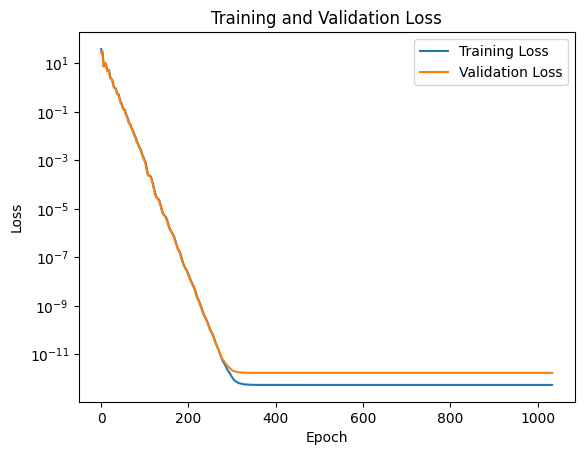

In [47]:
train_loss = history.history['loss'][1:1500]
val_loss = history.history['val_loss'][1:1500]

output_dir = 'plots-LSTM'
os.makedirs(output_dir, exist_ok=True)

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
# save the plot to the specified folder
plot_filename = f'loss.png'
plot_path = os.path.join(output_dir, plot_filename)
plt.savefig(plot_path)
plt.show()

**Plot the actual against the predicted values for all 6 cytokines**

1/1 [==============================] - 1s 588ms/step
(2500, 6)
(2500, 6)


C:\Users\Ioannis\AppData\Local\Temp\ipykernel_17964\3466415621.py:51: RuntimeWarning: divide by zero encountered in log
  log_y_test_grid = np.log(y_test_grid)
C:\Users\Ioannis\AppData\Local\Temp\ipykernel_17964\3466415621.py:52: RuntimeWarning: divide by zero encountered in log
  log_y_pred_grid = np.log(y_pred_grid)


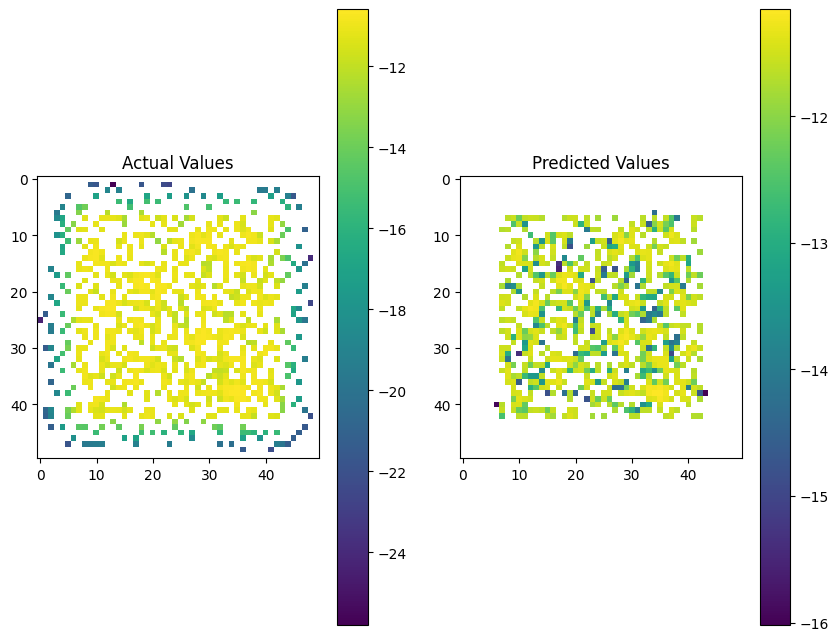

In [48]:
y_pred = model.predict(X_test)

y_pred_shape = y_pred.shape
y_test_shape = y_test.shape

# Flatten the y_pred and y_test tensors
y_pred_flattened = np.reshape(y_pred, (y_pred_shape[0], -1, y_pred_shape[-1]))
y_test_flattened = np.reshape(y_test, (y_test_shape[0], -1, y_test_shape[-1]))

# Calculate the mean squared error for each timestep
mse = np.mean((y_pred_flattened - y_test_flattened) ** 2, axis=(1, 2))

# Find the timestep with the smallest error
best_timestep = np.argmin(mse)

# Get the flattened values for the best timestep
best_y_pred_flattened = y_pred_flattened[best_timestep]
best_y_test_flattened = y_test_flattened[best_timestep]

# Create arrays for x and y coordinates for the best timestep
X = np.repeat(np.arange(y_test_shape[1]), y_test_shape[2])
Y = np.tile(np.arange(y_test_shape[2]), y_test_shape[1])

# Create the DataFrame for the best timestep
df_best_timestep = pd.DataFrame({
    'X': X,
    'Y': Y,
    **{f'feature_{i+1}': best_y_pred_flattened[:, i] for i in range(y_pred_shape[-1])}
})

# Save the DataFrame to a CSV file
df_best_timestep.to_csv('data/LSTM.csv', index=False)

# Verify shapes
print(best_y_test_flattened.shape)
print(best_y_pred_flattened.shape)

# Create plots for the best timestep
output_dir = 'plots-LSTM'
os.makedirs(output_dir, exist_ok=True)

num_features = best_y_test_flattened.shape[1]

feature_idx = 0

# Reshape the feature data to a 50x50 grid
y_test_grid = np.reshape(best_y_test_flattened[:, feature_idx], (50, 50))
y_pred_grid = np.reshape(best_y_pred_flattened[:, feature_idx], (50, 50))

# Apply log scale
log_y_test_grid = np.log(y_test_grid)
log_y_pred_grid = np.log(y_pred_grid)

plt.figure(figsize=(10, 8))

# Plotting actual values
plt.subplot(1, 2, 1)
plt.imshow(log_y_test_grid, cmap='viridis')
plt.title('Actual Values')
plt.colorbar()

# Plotting predicted values
plt.subplot(1, 2, 2)
plt.imshow(log_y_pred_grid, cmap='viridis')
plt.title('Predicted Values')
plt.colorbar()

# Save the plot to the specified folder
plot_filename = f'{feature_idx+1}_grid.png'
plot_path = os.path.join(output_dir, plot_filename)
plt.savefig(plot_path)

plt.show()

1/1 [==============================] - 0s 23ms/step


(2500, 6)
(2500, 6)


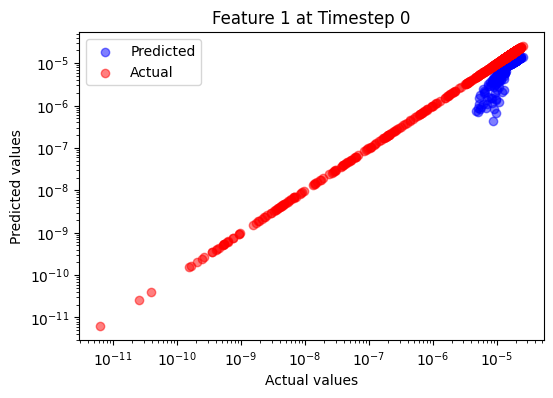

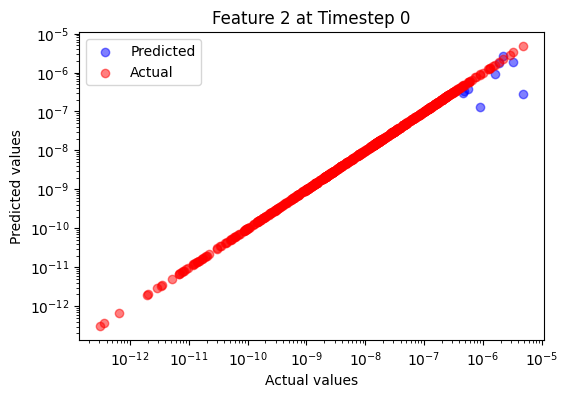

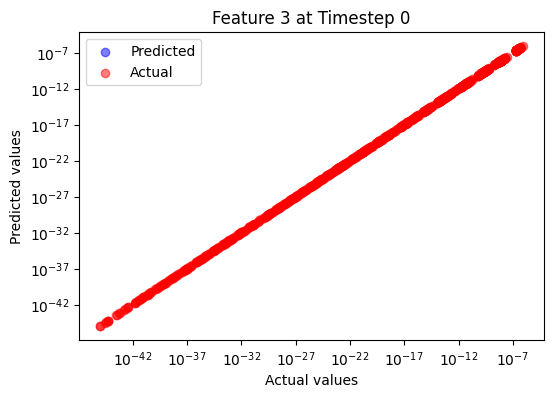

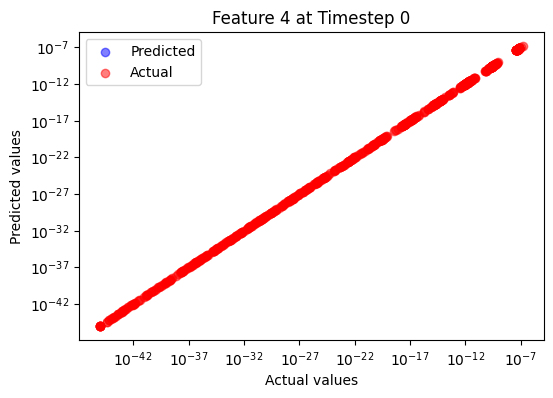

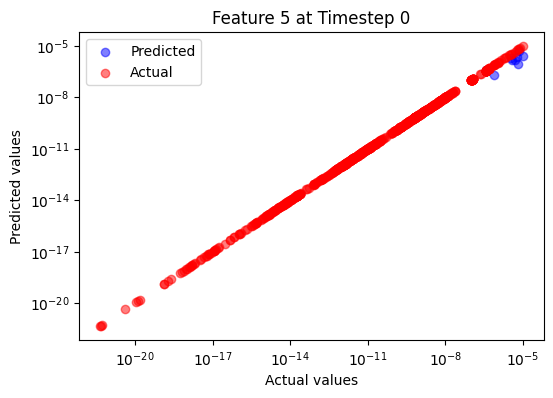

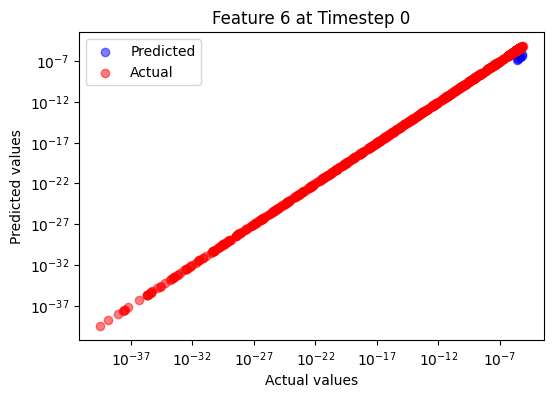

In [49]:
y_pred=model.predict(X_test)
y_pred_shape = y_pred.shape
y_test_shape = y_test.shape

# Flatten the y_pred and y_test tensors
y_pred_flattened = np.reshape(y_pred, (y_pred_shape[0], -1, y_pred_shape[-1]))
y_test_flattened = np.reshape(y_test, (y_test_shape[0], -1, y_test_shape[-1]))

# Calculate the mean squared error for each timestep
mse = np.mean((y_pred_flattened - y_test_flattened) ** 2, axis=(1, 2))

# Find the timestep with the smallest error
best_timestep = np.argmin(mse)

# Get the flattened values for the best timestep
best_y_pred_flattened = y_pred_flattened[best_timestep]
best_y_test_flattened = y_test_flattened[best_timestep]

# Create arrays for x and y coordinates for the best timestep
X = np.repeat(np.arange(y_test_shape[1]), y_test_shape[2])
Y = np.tile(np.arange(y_test_shape[2]), y_test_shape[1])

# Create the DataFrame for the best timestep
df_best_timestep = pd.DataFrame({
    'X': X,
    'Y': Y,
    **{f'feature_{i+1}': best_y_pred_flattened[:, i] for i in range(y_pred_shape[-1])}
})

# Save the DataFrame to a CSV file
df_best_timestep.to_csv('data/LSTM.csv', index=False)

# Verify shapes
print(best_y_test_flattened.shape)
print(best_y_pred_flattened.shape)

# Create plots for the best timestep
output_dir = 'plots-LSTM'
os.makedirs(output_dir, exist_ok=True)

num_features = best_y_test_flattened.shape[1]
for i in range(num_features):
    plt.figure(figsize=(6, 4))
    plt.scatter(best_y_test_flattened[:, i], best_y_pred_flattened[:, i], color='blue', alpha=0.5, label='Predicted')
    plt.scatter(best_y_test_flattened[:, i], best_y_test_flattened[:, i], color='red', alpha=0.5, label='Actual')
    plt.title(f'Feature {i+1} at Timestep {best_timestep}')
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    
    # Save the plot to the specified folder
    plot_filename = f'feature_{i+1}.png'
    plot_path = os.path.join(output_dir, plot_filename)
    plt.savefig(plot_path)
    
    plt.show()

In [ ]:
y_pred=model.predict(X_test)
print(y_test.shape)
print(y_pred.shape)
y_pred_shape = y_pred.shape
y_test_shape=y_test.shape

# reshape the tensor to (91*50*50, 6)
y_pred_flattened = np.reshape(y_pred, (-1, y_pred_shape[-1]))
y_test_flattened = np.reshape(y_test, (-1, y_test_shape[-1]))

df = pd.DataFrame(y_pred_flattened, columns=[f'feature_{i+1}' for i in range(y_pred_shape[-1])])

df.to_csv('data/ConvLSTM.csv', index=False)

print(y_test_flattened.shape)
print(y_pred_flattened.shape)

output_dir = 'plots-ConvLSTM'
os.makedirs(output_dir, exist_ok=True)

num_features = y_test_flattened.shape[1]
for i in range(num_features):
    plt.figure(figsize=(6, 4))
    plt.scatter(y_test_flattened[:, i], y_pred_flattened[:, i], color='blue', alpha=0.5, label='Predicted')
    plt.scatter(y_test_flattened[:, i], y_test_flattened[:, i], color='red', alpha=0.5, label='Actual')
    plt.title(f'Feature {i+1}')
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    
    # save the plot to the specified folder
    plot_filename = f'feature_{i+1}.png'
    plot_path = os.path.join(output_dir, plot_filename)
    plt.savefig(plot_path)
    
    plt.show()

**Basic transformer model**

In [17]:
from tensorflow.keras import layers, models, optimizers, losses

# input_sequences.shape = (91, 10, 50, 50, 6)
# output_values.shape = (91, 50, 50, 6)

# Define custom metrics
def r_squared(y_true, y_pred):
    SS_res = tf.keras.backend.sum(tf.keras.backend.square(y_true - y_pred))
    SS_tot = tf.keras.backend.sum(tf.keras.backend.square(y_true - tf.keras.backend.mean(y_true)))
    return 1 - SS_res / (SS_tot + tf.keras.backend.epsilon())

def average_relative_rmse(y_true, y_pred):
    return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square((y_pred - y_true) / tf.keras.backend.clip(tf.keras.backend.abs(y_true), tf.keras.backend.epsilon(), None))))

def lr_schedule(epoch, lr):
    if epoch < 100:
        return 1e-2
    if epoch < 500:
        return 1e-3
    else:
        return 1e-4

train_size = int(0.7 * len(input_sequences))
val_size = int(0.1 * len(input_sequences))

X_train, y_train = input_sequences[:train_size], output_values[:train_size]
X_val, y_val = input_sequences[train_size:train_size+val_size], output_values[train_size:train_size+val_size]
X_test, y_test = input_sequences[train_size+val_size:], output_values[train_size+val_size:]

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = models.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class PositionalEncoding(layers.Layer):
    def __init__(self, maxlen, embed_dim):
        super(PositionalEncoding, self).__init__()
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-2]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        return x + positions

def build_transformer_model(input_shape, num_heads, ff_dim):
    inputs = layers.Input(shape=input_shape)
    x = layers.TimeDistributed(layers.Conv2D(8, (3, 3), padding='same', activation='relu'))(inputs)
    x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x)
    x = layers.TimeDistributed(layers.Conv2D(16, (3, 3), padding='same', activation='relu'))(x)
    x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x)
    
    x = layers.Reshape((input_shape[0], -1))(x)
    
    embed_dim = x.shape[-1]
    x = PositionalEncoding(input_shape[0], embed_dim)(x)
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    x = transformer_block(x)
    
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(50 * 50 * 6)(x)
    outputs = layers.Reshape((50, 50, 6))(x)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

input_shape = (sequence_length, 50, 50, 6)
num_heads = 2  
ff_dim = 16    
model = build_transformer_model(input_shape, num_heads, ff_dim)

model.compile(optimizer='adam', loss='mse', metrics=[r_squared, 'mape', average_relative_rmse, 'msle', 'mae'])

batch_size = 16
lr_scheduler = LearningRateScheduler(lr_schedule)
early_stopping = EarlyStopping(monitor='val_loss', patience=150, verbose=1, restore_best_weights=True)

initial_lr = 1e-2

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=batch_size, callbacks=[lr_scheduler, early_stopping])


test_metrics = model.evaluate(X_test, y_test)
print(f'Test Metrics: {test_metrics}')

model.summary()

KeyboardInterrupt: 